In [67]:
import math, random
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.optim as optim

import torch.autograd as autograd
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [68]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [69]:
class PrioritizedBuffer():
  def __init__(self, max_samples, alpha=0.6):
    self.alpha = alpha
    self.max_samples = max_samples 
    self.buffer = []
    self.index = 0
    self.priorities = np.zeros((max_samples,), dtype= np.float32)

  def store(self, state, action, reward , next_state, done):
    assert state.ndim == next_state.ndim
    state =  np.expand_dims(state,0)
    next_state = np.expand_dims(next_state,0)

    max_priority = self.priorities.max() if self.buffer else 1.0

    if len(self.buffer) < self.max_samples:
      self.buffer.append((state, action, reward, next_state,done))
    else:
      self.buffer[self.index] =  (state, action, reward, next_state,done)

    self.priorities[self.index] = max_priority
    self.index = (self.index +1) % self.max_samples

  def sample(self,batch_size, beta=0.4):
    if len(self.buffer) == self.max_samples:
      priority = self.priorities
    else:
      priority = self.priorities[:self.index]

    #Proportional prioritization
    probs = priority ** self.alpha
    probs /= probs.sum()

    indices =np.random.choice(len(self.buffer),batch_size,p=probs)
    samples = [self.buffer[i] for i in indices]

    total = len(self.buffer)
    weights =  (total * probs[indices]) ** (-beta)
    weights /= weights.max()
    weights = np.array(weights,dtype =np.float32)

    experiences = list(zip(*samples))
    states =  np.concatenate(experiences[0])
    actions = experiences[1]
    rewards = experiences[2]
    next_states = np.concatenate(experiences[3])
    done_flags = experiences[4]  

    return states, actions, rewards, next_states, done_flags, indices, weights

      
  def update(self, exp_indices , exp_priorities):
    for i, p in zip(exp_indices, exp_priorities) :
      self.priorities[i] = p

  def __len__(self):
    return len(self.buffer)

  def __repr__(self):
    return str(self.buffer[:self.max_samples])

  def __str__(self):
    return str(self.buffer[:self.max_samples])  


In [70]:
beta_start= 0.4
beta_rate = 1000
beta_by_rate = lambda i: min(1.0 , beta_start +i * (1.0 - beta_start) / beta_rate)

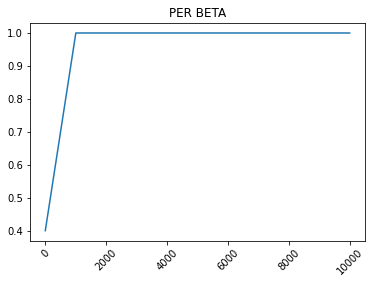

In [71]:
plt.plot([rate(i) for i in range(10000)])
plt.title('PER BETA')
plt.xticks(rotation=45)
plt.show()

In [72]:
env = gym.make("CartPole-v0")

In [73]:
epsilon_decay = 500
epsilon_final = 0.01
epsilon_start = 1.0
epsilon_rate = lambda i:epsilon_final +(epsilon_start - epsilon_final) * math.exp(-1. * i / epsilon_decay)

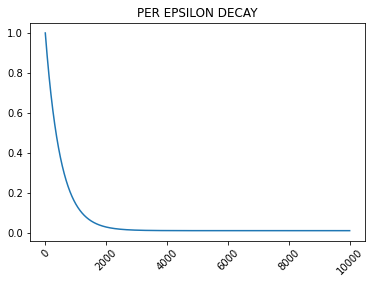

In [74]:
plt.plot([epsilon_rate(i) for i in range(10000)])
plt.title('PER EPSILON DECAY')
plt.xticks(rotation=45)
plt.show()

In [75]:
#DQN
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [76]:
current_net = DQN(env.observation_space.shape[0], env.action_space.n)
target_net  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_net = current_net.cuda()
    target_net = target_net.cuda()

optimizer = optim.Adam(current_net.parameters())

replay_buffer = PrioritizedBuffer(100000)

In [77]:
#Synchronize current policy net and target net 
def targetUpdate(current_net,target_net):
  target_net.load_state_dict(current_net.state_dict())

targetUpdate(current_net,target_net)  

In [82]:
"""
Td loss is the indicator for the "surprise" experiences which needs to prioritized for faster and easier learning
"""
def tdLoss(batch_size, beta):
  state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta) 
    
  state      = Variable(torch.FloatTensor(np.float32(state)))
  next_state = Variable(torch.FloatTensor(np.float32(next_state)))
  action     = Variable(torch.LongTensor(action))
  reward     = Variable(torch.FloatTensor(reward))
  done       = Variable(torch.FloatTensor(done))
  weights    = Variable(torch.FloatTensor(weights))

  q_values      = current_net(state)
  next_q_values = target_net(next_state)

  q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
  next_q_value     = next_q_values.max(1)[0]
  expected_q_value = reward + gamma * next_q_value * (1 - done)
    
  loss  = (q_value - expected_q_value.detach()).pow(2) * weights
  prios = loss + 1e-5
  loss  = loss.mean()
        
  optimizer.zero_grad()
  loss.backward()
  replay_buffer.update(indices, prios.data.cpu().numpy())
  optimizer.step()
    
  return loss


In [79]:
def plot(index, rewards, losses):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('FRAME %s. REWARD: %s' % (index, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('LOSS')
    plt.plot(losses)
    plt.show()    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


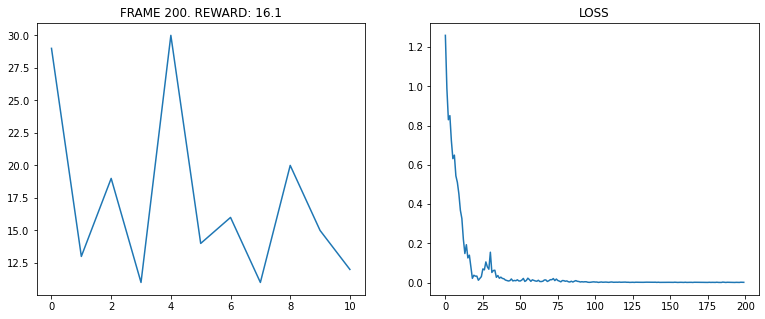

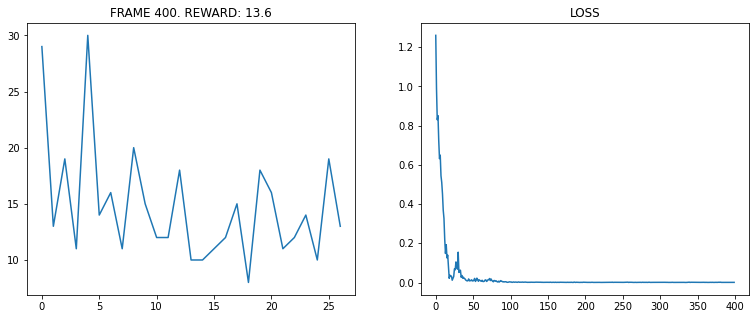

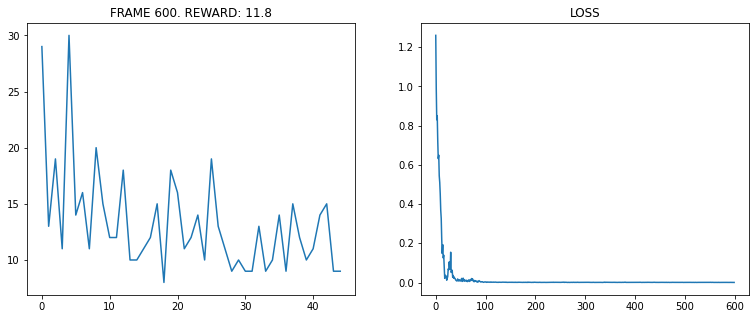

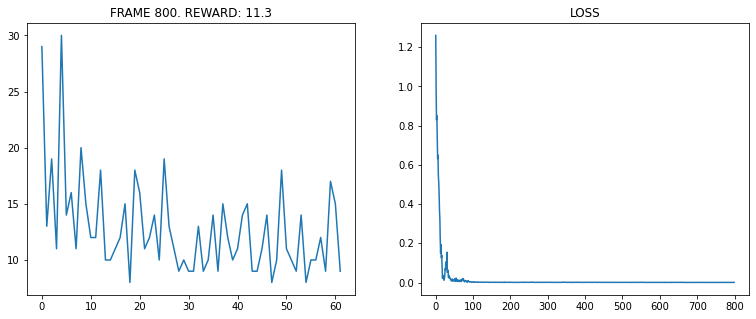

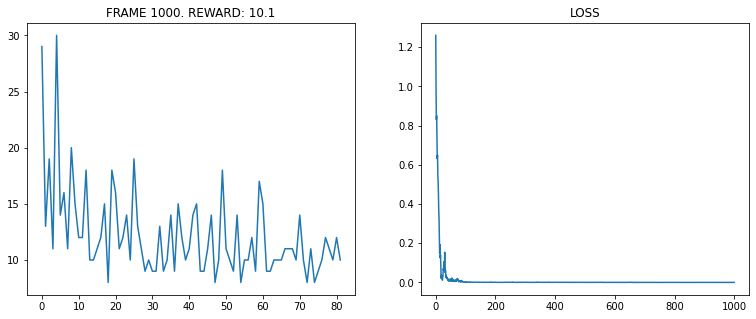

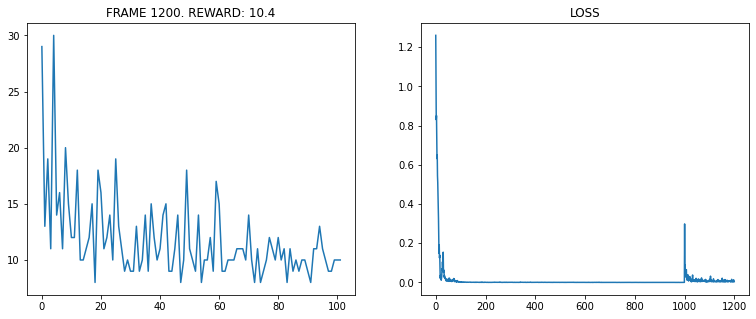

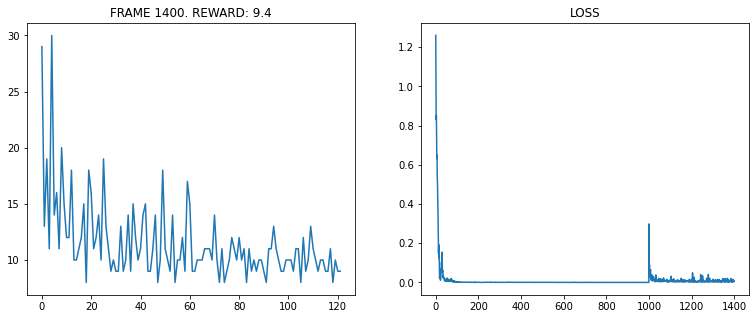

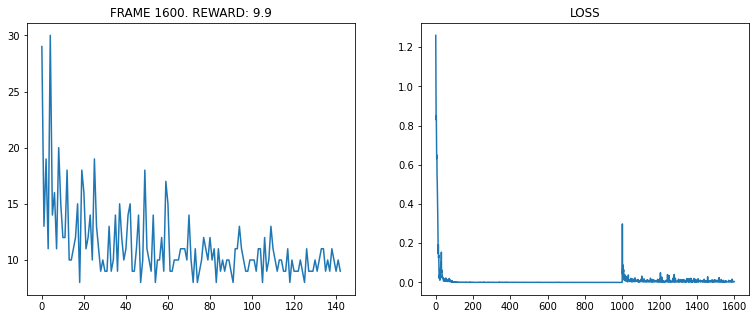

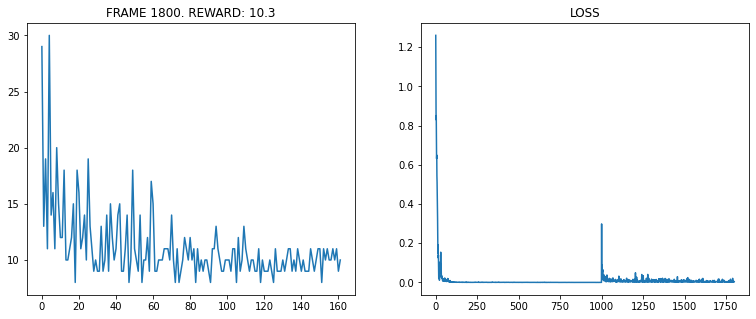

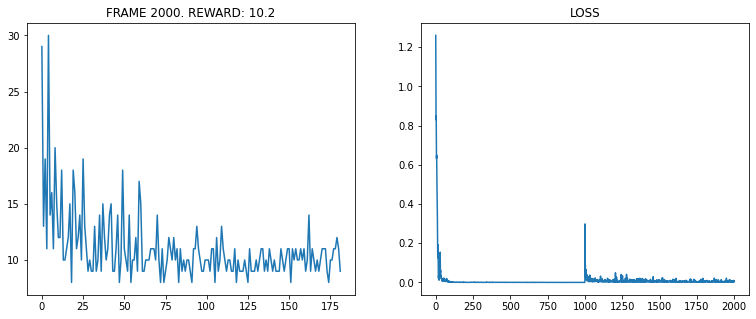

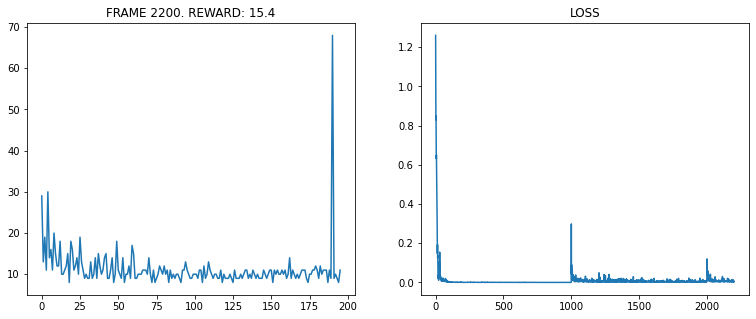

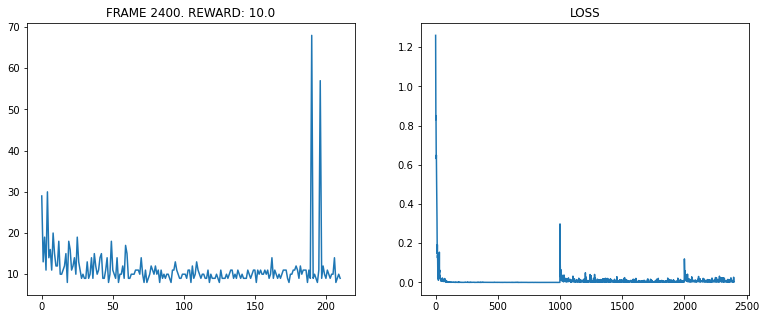

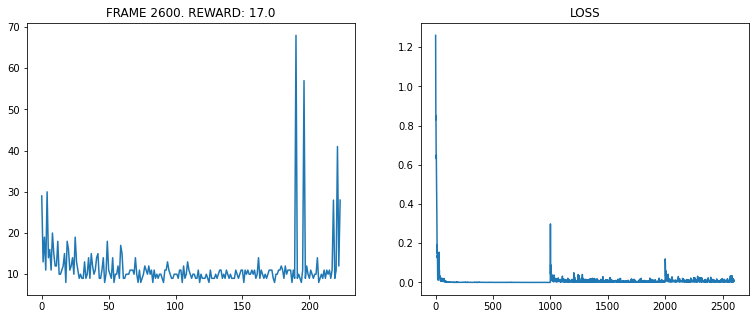

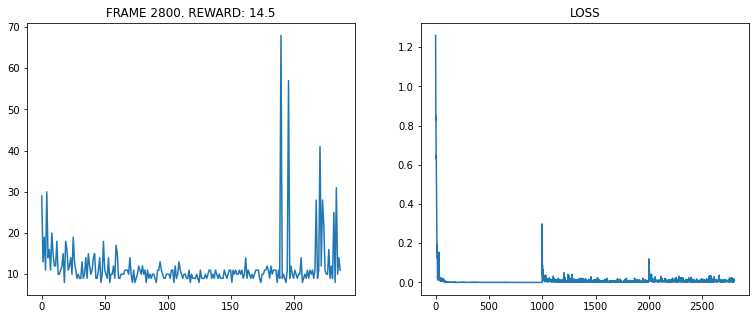

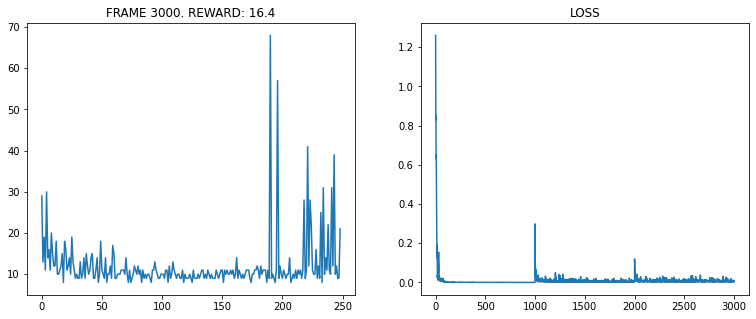

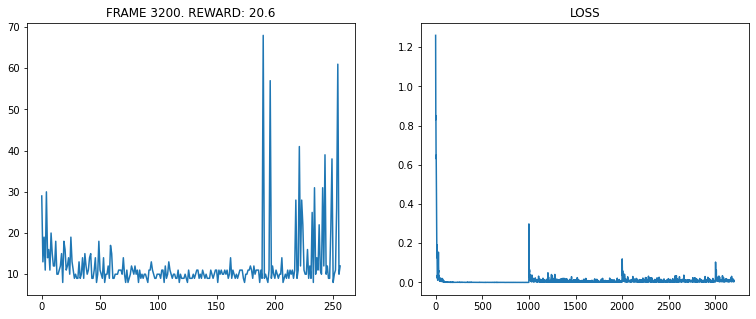

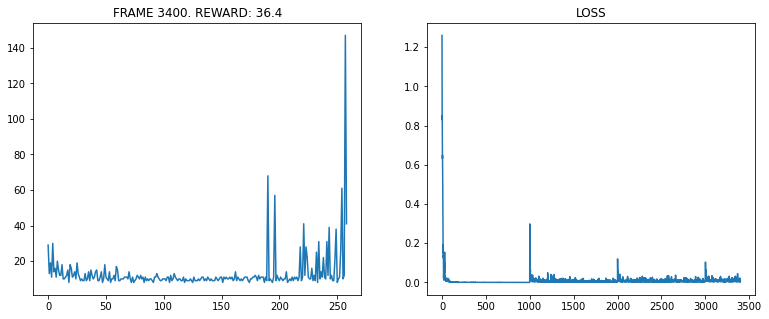

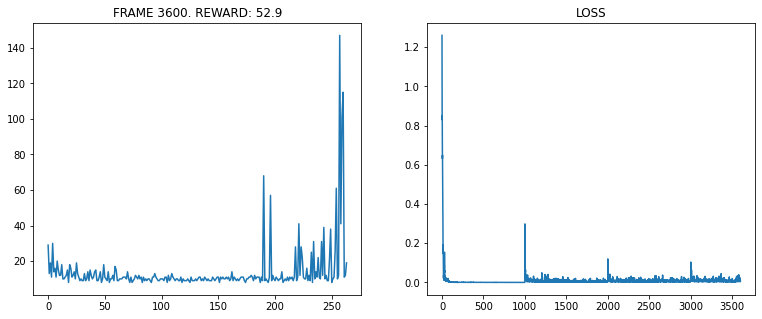

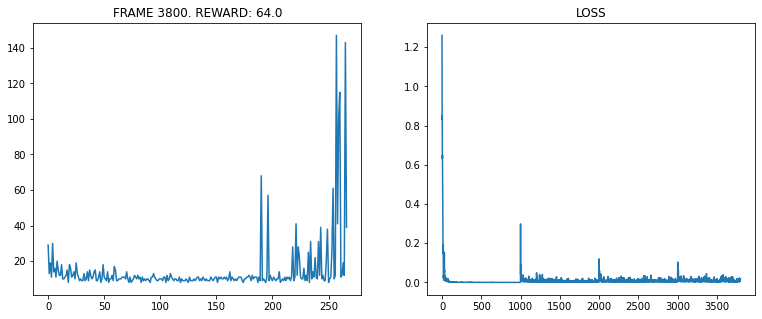

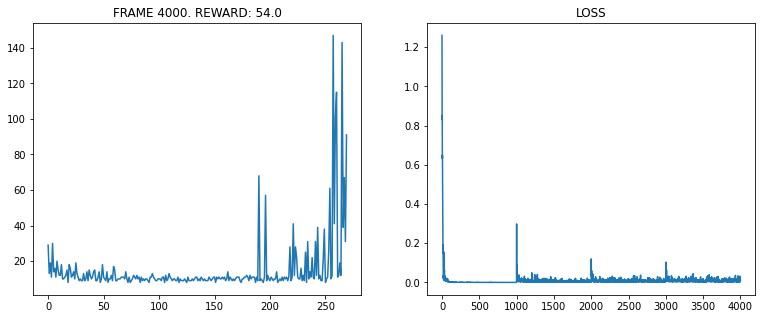

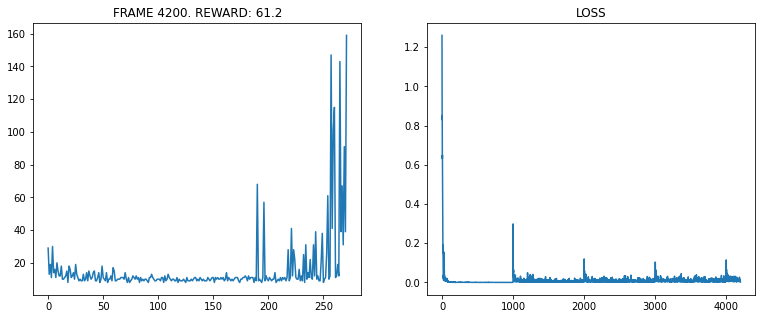

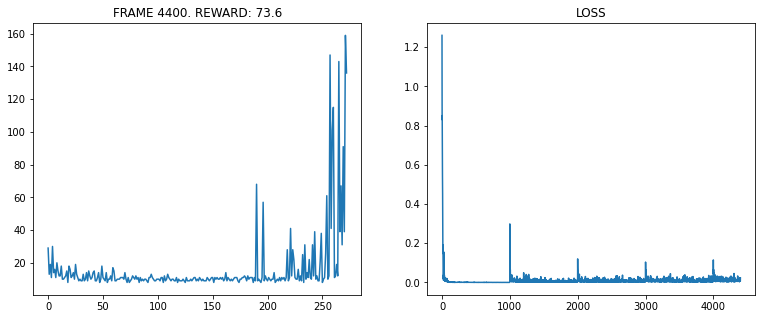

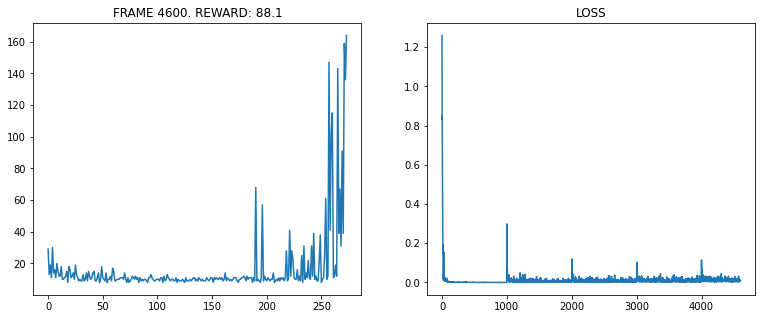

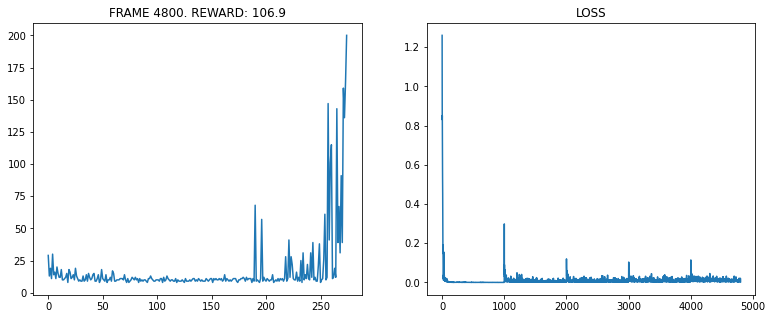

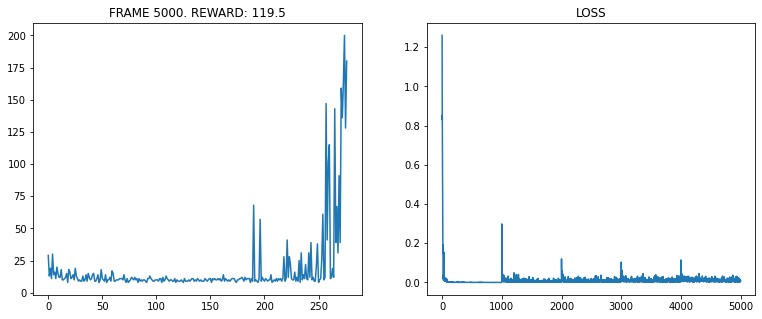

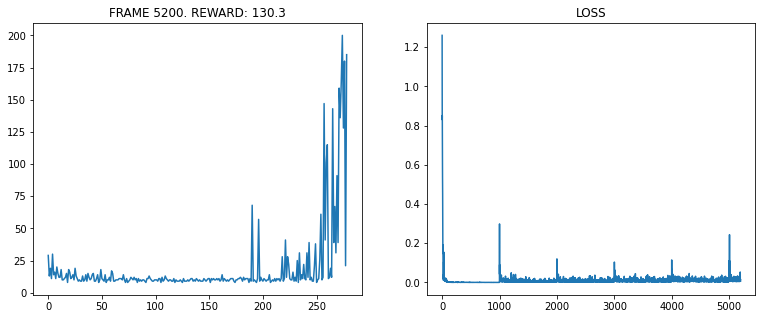

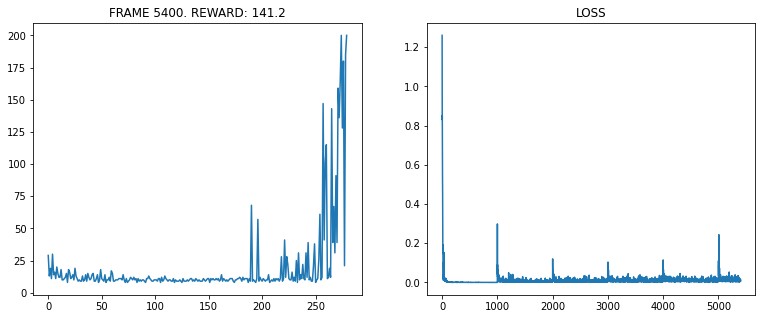

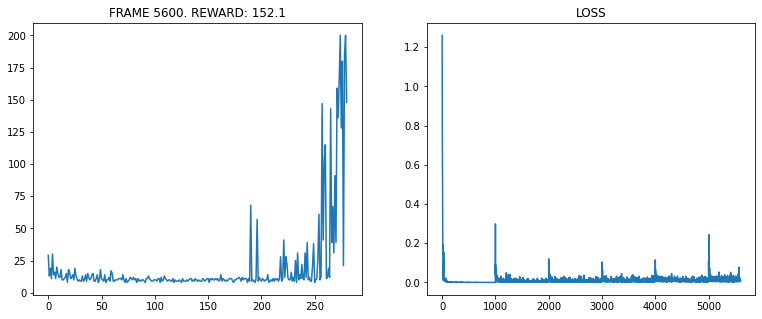

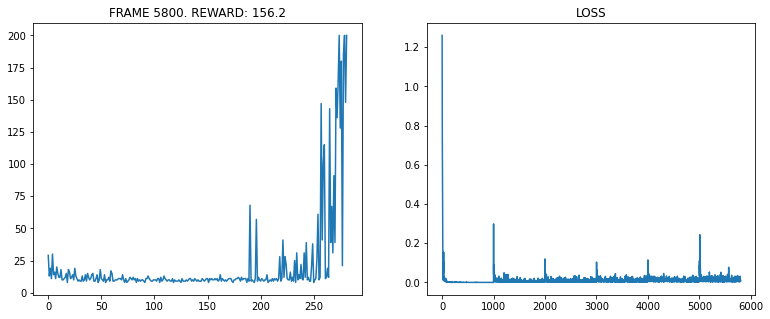

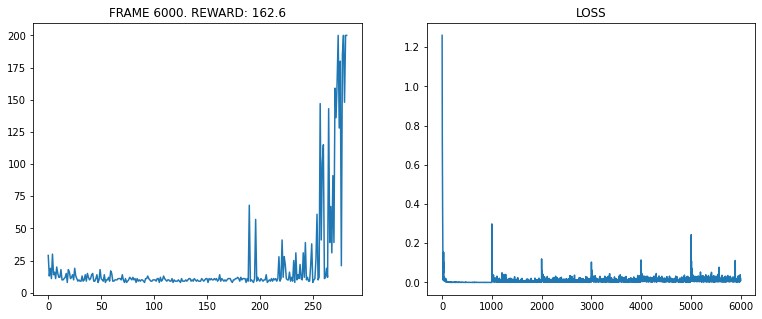

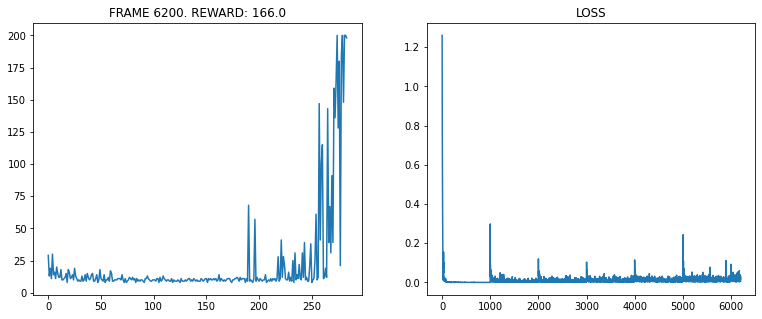

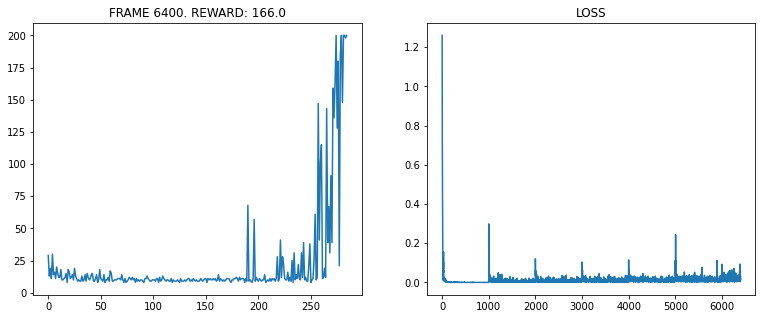

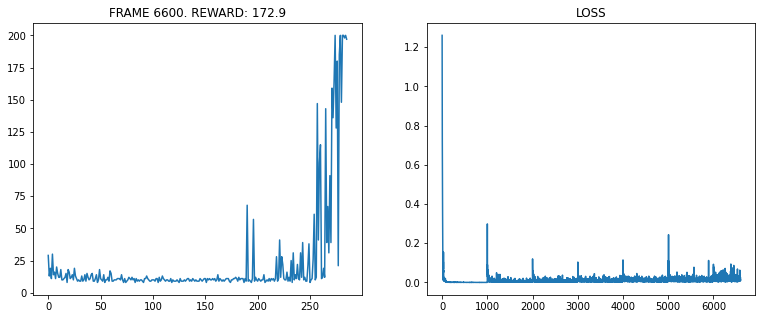

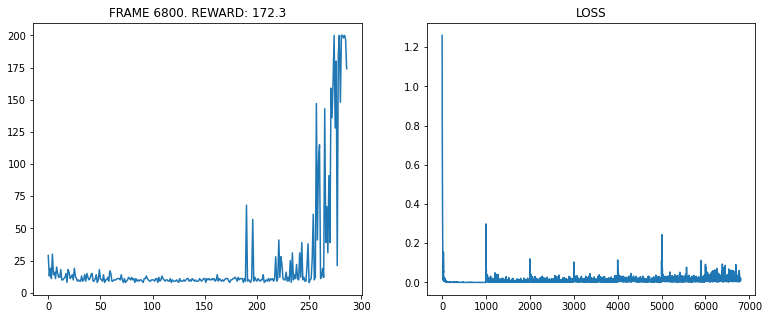

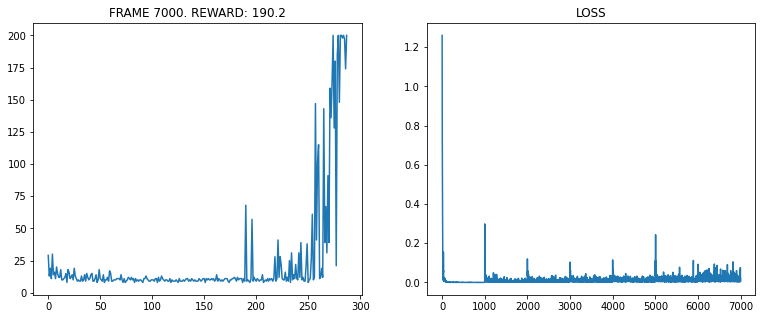

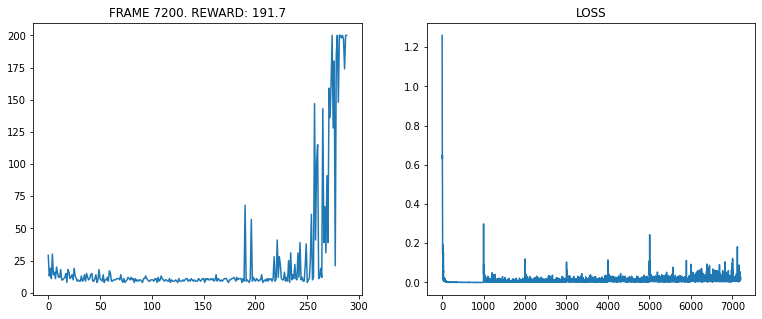

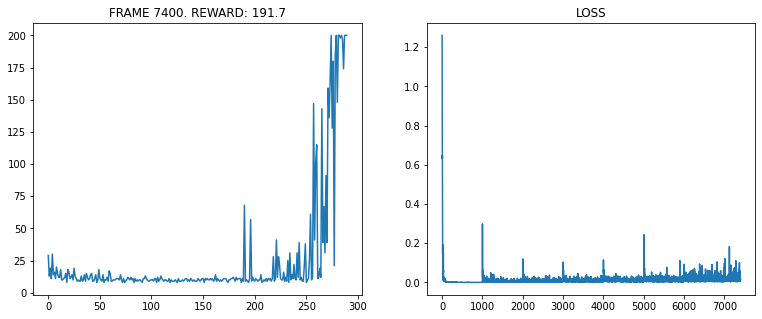

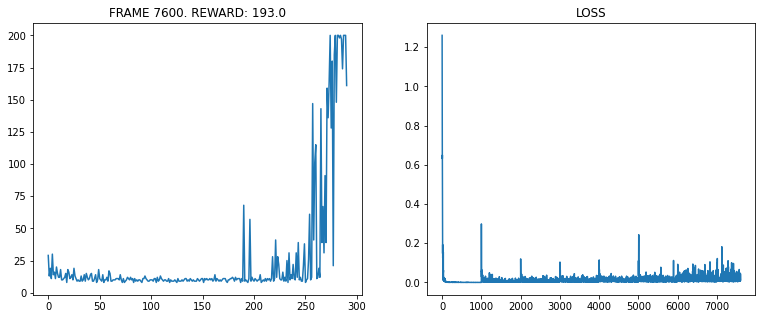

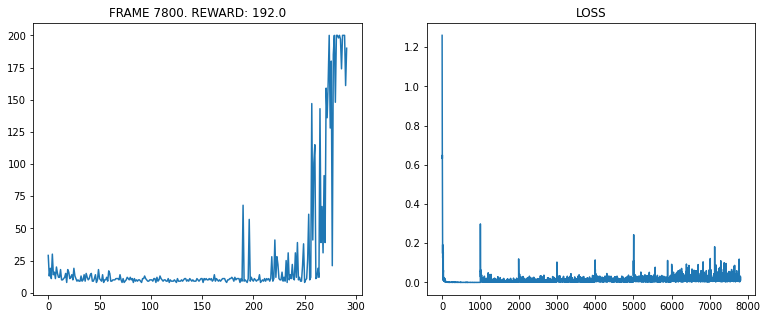

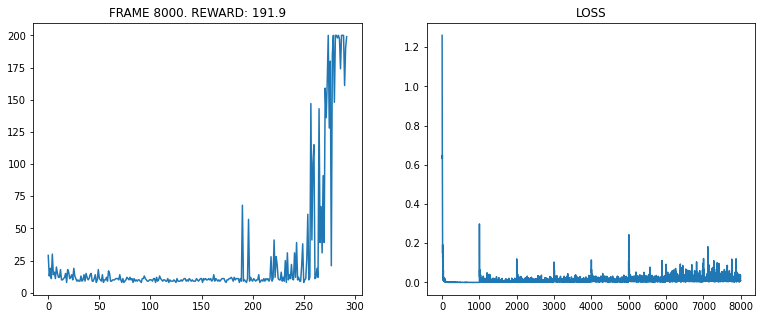

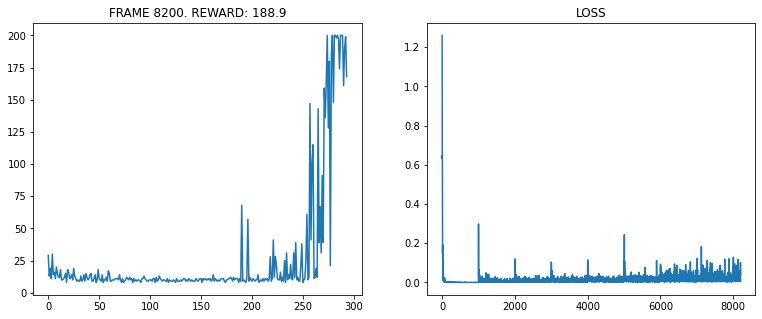

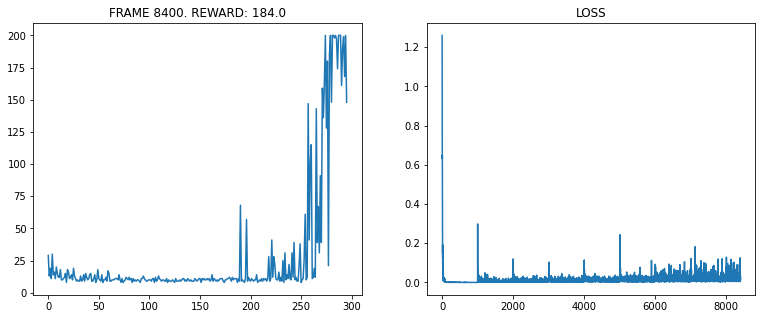

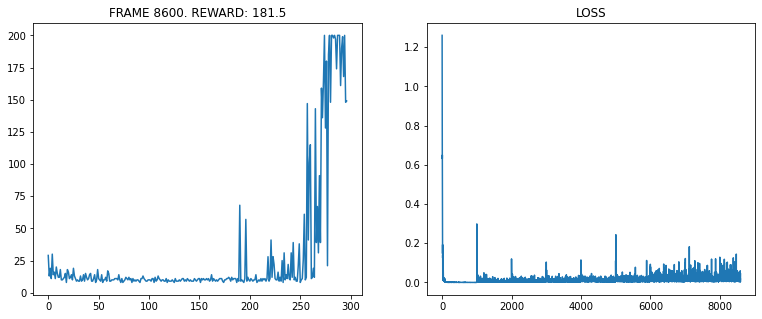

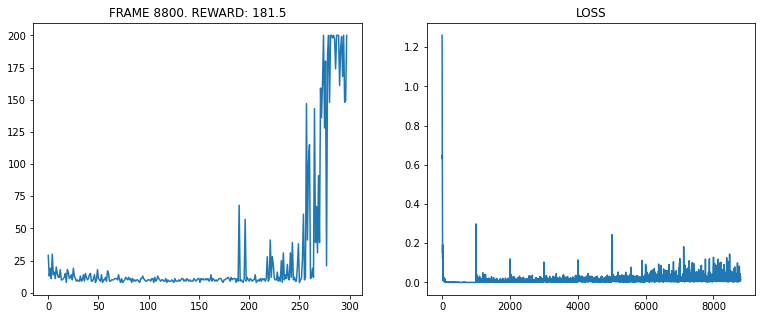

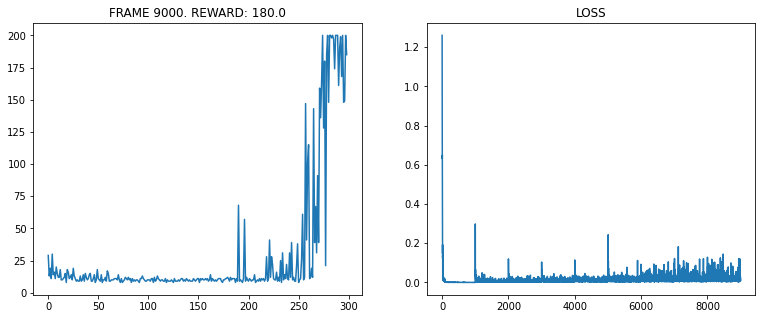

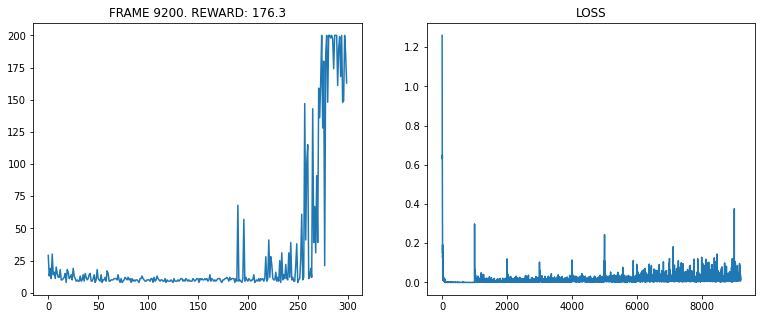

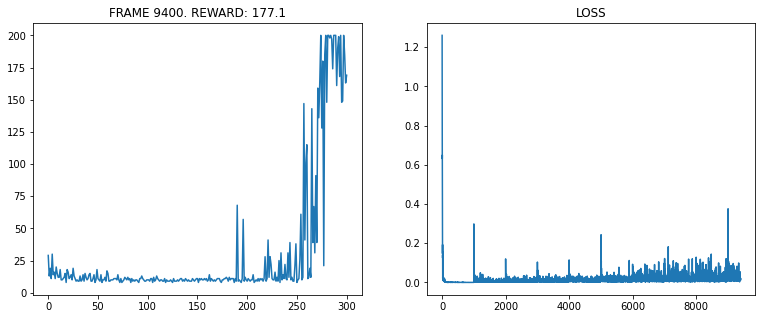

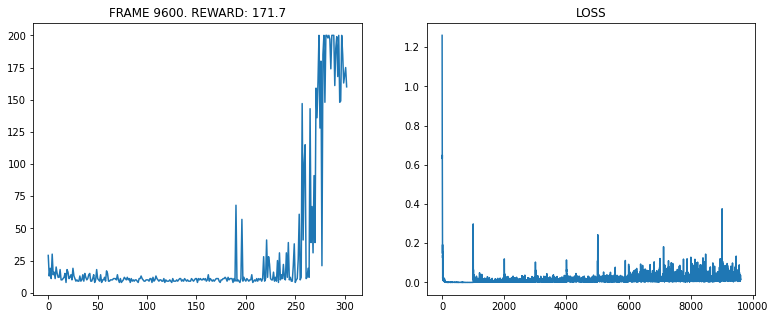

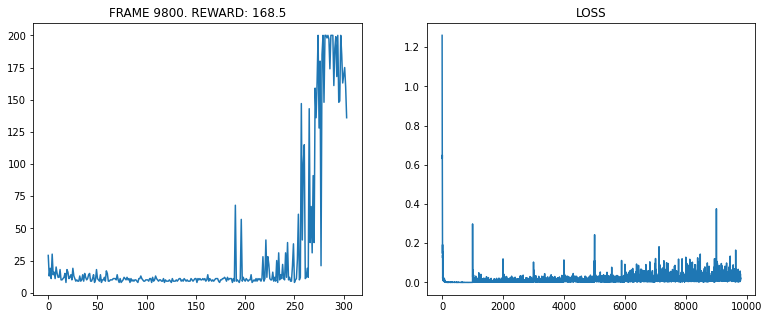

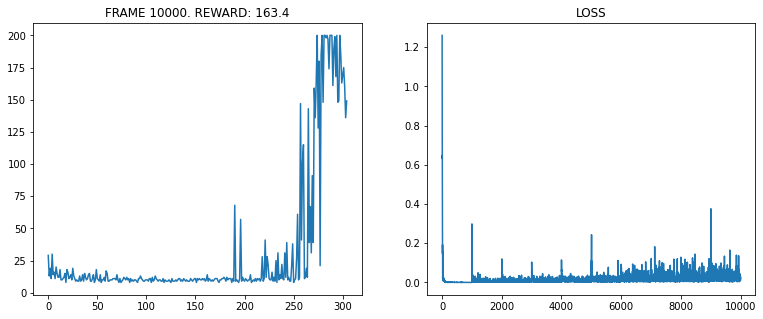

In [83]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for i in range(1, num_frames + 1):
    epsilon = epsilon_rate(i)
    action = current_net.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
    replay_buffer.store(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_rate(i)
        loss = tdLoss(batch_size, beta)
        losses.append(loss.item())
        
    if i % 200 == 0:
        plot(i, all_rewards, losses)
        
    if i % 1000 == 0:
        targetUpdate(current_net, target_net)